In [1]:
import torch

from train_sae.saes.crosscoder import CrossCoderSAE

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [3]:
device = "cuda:1"
addition_cc = CrossCoderSAE(2, 128, 2048, "vanilla", {"sparsity": 0.01}).to(device)
addition_cc.load_state_dict(
    torch.load(
        "/home/cadegord/projects/train-SAE/wandb/run-20250502_014519-8fvbi087/files/model_25000_flops_1.61e+14.pt",
        map_location=device,
    )
)

# make same plot from above for addition cc weights
addition_dec1_weights = addition_cc.autoencoders[0].decoder.weight.detach()
addition_dec2_weights = addition_cc.autoencoders[1].decoder.weight.detach()

/tmp/ipykernel_2424345/1021917755.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


([<matplotlib.axis.XTick at 0x7a323cd8d1c0>,
 [Text(0.0, 0, 'Post-Generalization\nFeatures'),
  Text(0.5, 0, 'Shared\nFeatures'),
  Text(1.0, 0, 'Pre-Generalization\nFeatures')])

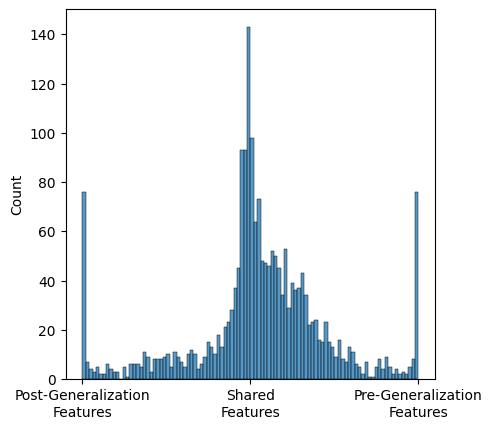

In [4]:
# make same plot from above for addition cc weights
addition_dec1_weight_norms = addition_dec1_weights.norm(dim=0)
addition_dec2_weight_norms = addition_dec2_weights.norm(dim=0)

addition_relative_norms = addition_dec1_weight_norms / (
    addition_dec1_weight_norms + addition_dec2_weight_norms
)

sns.histplot(addition_relative_norms.numpy(force=True), bins=100)
plt.gca().set_box_aspect(1)
plt.xticks(
    [0, 0.5, 1],
    [
        "Post-Generalization\nFeatures",
        "Shared\nFeatures",
        "Pre-Generalization\nFeatures",
    ],
)

# Begin Analysis

In [5]:
from train_sae.models.transformer import trunk_and_head_from_pretrained

In [6]:
pre_feat, pre_decoder = trunk_and_head_from_pretrained(
    "/home/cadegord/projects/transformerzoo/private/grokking/subtraction-freq-causal-ln/1700-train=1.00-test=0.14.pt",
    1,
    device,
    torch.float32,
    99,
    128,
    512,
    4,
    2,
    use_geglu=False,
    max_seq_len=2048,
    use_learned_pos_emb=True,
    norm_layer="LayerNorm",
)
post_feat, post_decoder = trunk_and_head_from_pretrained(
    "/home/cadegord/projects/transformerzoo/private/grokking/subtraction-freq-causal-ln/2400-train=1.00-test=1.00.pt",
    1,
    device,
    torch.float32,
    99,
    128,
    512,
    4,
    2,
    use_geglu=False,
    max_seq_len=2048,
    use_learned_pos_emb=True,
    norm_layer="LayerNorm",
)

/home/cadegord/projects/train-SAE/train_sae/models/transformer.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [7]:
# print device of the above 3 models
print(pre_feat.embeddings.weight.device)
print(post_feat.embeddings.weight.device)
print(addition_cc.autoencoders[0].decoder.weight.device)

cuda:1
cuda:1
cuda:1


In [8]:
# create train and test addition data
from itertools import product

from torch.utils.data import DataLoader

prime = 97

data = []
for a, b in product(range(prime), range(prime)):
    data.append([a, 97, b, 98, (a - b) % prime])

data = torch.tensor(data)

generator = torch.Generator().manual_seed(42)
train_data, test_data = torch.utils.data.random_split(
    data, [0.5, 0.5], generator=generator
)

train_dataloader = DataLoader(
    train_data,
    batch_size=512,
    shuffle=True,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=512,
    shuffle=False,
    pin_memory=True,
)

In [9]:
# get train and test accuracy without a cross coder
train_correct = 0
train_total = 0
for batch in train_dataloader:
    batch = batch.long()
    batch = batch.to(device)
    x, y = batch[:, :4], batch[:, 4]
    with torch.no_grad():
        preds = pre_decoder(pre_feat(x))[:, -1, :]
        # preds = pre_transformer(x)[:, -1, :]
        train_correct += (preds.argmax(dim=1) == y).sum().item()
        train_total += y.size(0)
print(f"Train accuracy: {train_correct / train_total}")

test_correct = 0
test_total = 0
for batch in test_dataloader:
    x, y = batch[:, :-1].to(device), batch[:, -1].to(device)
    with torch.no_grad():
        preds = pre_decoder(pre_feat(x))[:, -1, :]
        # preds = pre_transformer(x)[:, -1, :]
        test_correct += (preds.argmax(dim=1) == y).sum().item()
        test_total += y.size(0)
print(f"Test accuracy: {test_correct / test_total}")

Train accuracy: 0.9985122210414453
Test accuracy: 0.1447704081632653


In [10]:
# get train and test accuracy with a cross coder
pre_train_correct = 0
pre_train_total = 0
post_train_correct = 0
post_train_total = 0
for batch in train_dataloader:
    batch = batch.long()
    batch = batch.to(device)
    x, y = batch[:, :4], batch[:, 4]
    with torch.no_grad():
        zs = [pre_feat(x), post_feat(x)]
        z_normalizing_factors = [
            pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
        ]
        zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
        encoded = addition_cc.encode(zs)
        z_hats = [
            autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
        ]
        z_hats = [z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)]
        pre_preds = pre_decoder(z_hats[0])[:, -1, :]
        post_preds = post_decoder(z_hats[1])[:, -1, :]
        pre_train_correct += (pre_preds.argmax(dim=1) == y).sum().item()
        pre_train_total += y.size(0)
        post_train_correct += (post_preds.argmax(dim=1) == y).sum().item()
        post_train_total += y.size(0)
print(f"Pre train accuracy: {pre_train_correct / pre_train_total}")
print(f"Post train accuracy: {post_train_correct / post_train_total}")

pre_test_correct = 0
pre_test_total = 0
post_test_correct = 0
post_test_total = 0
for batch in test_dataloader:
    batch = batch.long()
    batch = batch.to(device)
    x, y = batch[:, :4], batch[:, 4]
    with torch.no_grad():
        zs = [pre_feat(x), post_feat(x)]
        z_normalizing_factors = [
            pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
        ]
        zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
        encoded = addition_cc.encode(zs)
        z_hats = [
            autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
        ]
        z_hats = [z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)]
        pre_preds = pre_decoder(z_hats[0])[:, -1, :]
        post_preds = post_decoder(z_hats[1])[:, -1, :]
        pre_test_correct += (pre_preds.argmax(dim=1) == y).sum().item()
        pre_test_total += y.size(0)
        post_test_correct += (post_preds.argmax(dim=1) == y).sum().item()
        post_test_total += y.size(0)
print(f"Pre test accuracy: {pre_test_correct / pre_test_total}")
print(f"Post test accuracy: {post_test_correct / post_test_total}")

Pre train accuracy: 0.9982996811902232
Post train accuracy: 1.0
Pre test accuracy: 0.1445578231292517
Post test accuracy: 0.9982993197278912


In [11]:
def get_train_test_accuracy(feat_idxs: list[int], multiplier: float = 0.0):
    # get train and test accuracy with a cross coder
    pre_train_correct = 0
    pre_train_total = 0
    post_train_correct = 0
    post_train_total = 0
    for batch in train_dataloader:
        batch = batch.long()
        batch = batch.to(device)
        x, y = batch[:, :4], batch[:, 4]
        with torch.no_grad():
            zs = [pre_feat(x), post_feat(x)]
            z_normalizing_factors = [
                pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
            ]
            zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
            encoded = addition_cc.encode(zs)
            encoded[:, :, feat_idxs] = encoded[:, :, feat_idxs] * multiplier
            z_hats = [
                autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
            ]
            z_hats = [
                z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)
            ]
            pre_preds = pre_decoder(z_hats[0])[:, -1, :]
            post_preds = post_decoder(z_hats[1])[:, -1, :]
            pre_train_correct += (pre_preds.argmax(dim=1) == y).sum().item()
            pre_train_total += y.size(0)
            post_train_correct += (post_preds.argmax(dim=1) == y).sum().item()
            post_train_total += y.size(0)

    pre_test_correct = 0
    pre_test_total = 0
    post_test_correct = 0
    post_test_total = 0
    for batch in test_dataloader:
        batch = batch.long()
        batch = batch.to(device)
        x, y = batch[:, :4], batch[:, 4]
        with torch.no_grad():
            zs = [pre_feat(x), post_feat(x)]
            z_normalizing_factors = [
                pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
            ]
            zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
            encoded = addition_cc.encode(zs)
            encoded[:, :, feat_idxs] = encoded[:, :, feat_idxs] * multiplier
            z_hats = [
                autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
            ]
            z_hats = [
                z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)
            ]
            pre_preds = pre_decoder(z_hats[0])[:, -1, :]
            post_preds = post_decoder(z_hats[1])[:, -1, :]
            pre_test_correct += (pre_preds.argmax(dim=1) == y).sum().item()
            pre_test_total += y.size(0)
            post_test_correct += (post_preds.argmax(dim=1) == y).sum().item()
            post_test_total += y.size(0)

    return (
        pre_train_correct / pre_train_total,
        post_train_correct / post_train_total,
        pre_test_correct / pre_test_total,
        post_test_correct / post_test_total,
    )

In [12]:
pre_tr_acc, post_tr_acc, pre_te_acc, post_te_acc = get_train_test_accuracy([])

In [13]:
# get the sorted indices of relative norms of the addition cc weights
sorted_indices = torch.argsort(addition_relative_norms)

# Zero ablations

In [ ]:
results = []
for i in range(0, len(sorted_indices), 1):
    results.append(get_train_test_accuracy(sorted_indices[i : i + 1]))
results_np = np.array(results)
plt.plot(results_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

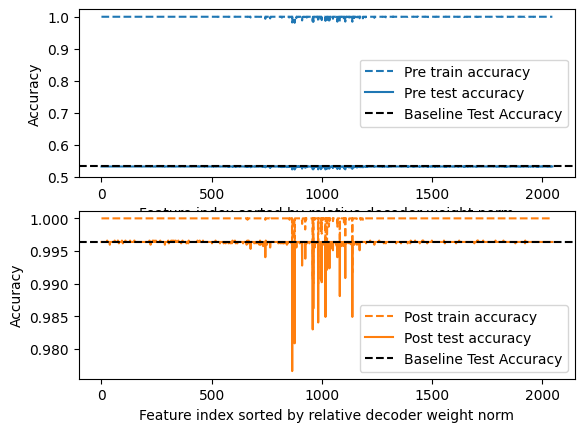

In [35]:
# make a plot of the results as follows:
# the pre model accuracies in blue
# the post model accuracies in orange
# the train accuracies dashed
# the test accuracies solid
results_np = np.array(results)
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(results_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
ax1.plot(results_np[:, 2], label="Pre test accuracy", color="C0")
ax1.axhline(pre_te_acc, color="black", linestyle="--", label="Baseline Test Accuracy")
ax1.set_xlabel("Feature index sorted by relative decoder weight norm")
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(results_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
ax2.plot(results_np[:, 3], label="Post test accuracy", color="C1")
ax2.axhline(post_te_acc, color="black", linestyle="--", label="Baseline Test Accuracy")
ax2.set_xlabel("Feature index sorted by relative decoder weight norm")
ax2.set_ylabel("Accuracy")
ax2.legend()

In [36]:
# count number of post train accuracies are perfect and post test accuracy has dropped
perfect_post_train_count = (results_np[:, 1] == 1) & (results_np[:, 3] < post_te_acc)
print(
    f"Number of post train accuracies that are perfect and post test accuracy has dropped: {perfect_post_train_count.sum()}"
)

Number of post train accuracies that are perfect and post test accuracy has dropped: 87


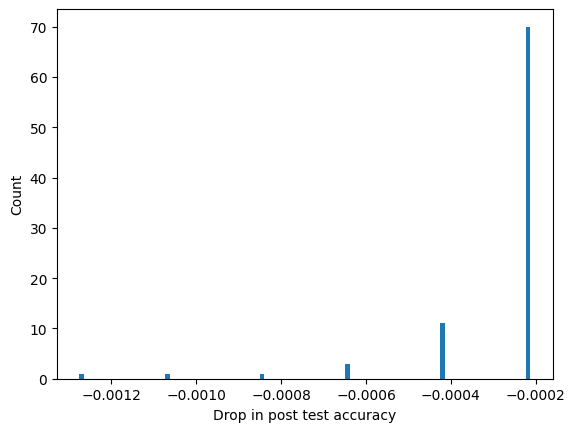

In [37]:
# make a histogram of the drops in post test accuracy
plt.hist(results_np[perfect_post_train_count, 3] - post_te_acc, bins=100)
plt.xlabel("Drop in post test accuracy")
plt.ylabel("Count")
plt.show()

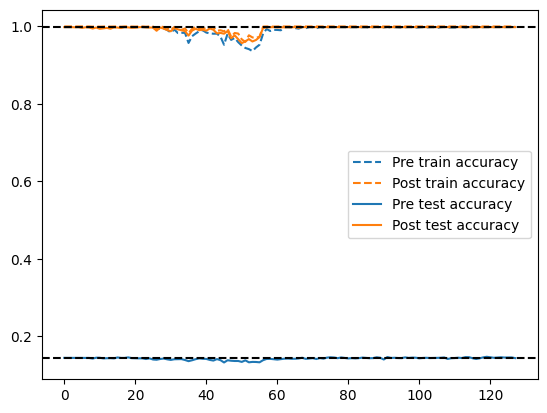

In [14]:
# repeat the above but use chunks of 16 features
results_16 = []
for i in range(0, len(sorted_indices), 16):
    results_16.append(get_train_test_accuracy(sorted_indices[i : i + 16]))
results_16_np = np.array(results_16)
plt.plot(results_16_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_16_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_16_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_16_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

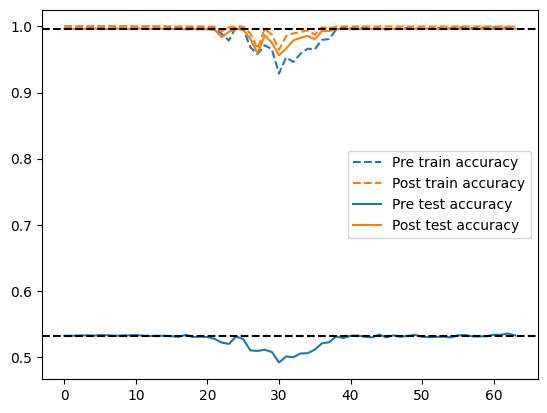

In [38]:
# repeat the above but use chunks of 32 features
results_32 = []
for i in range(0, len(sorted_indices), 32):
    results_32.append(get_train_test_accuracy(sorted_indices[i : i + 32]))
results_32_np = np.array(results_32)
plt.plot(results_32_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_32_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_32_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_32_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

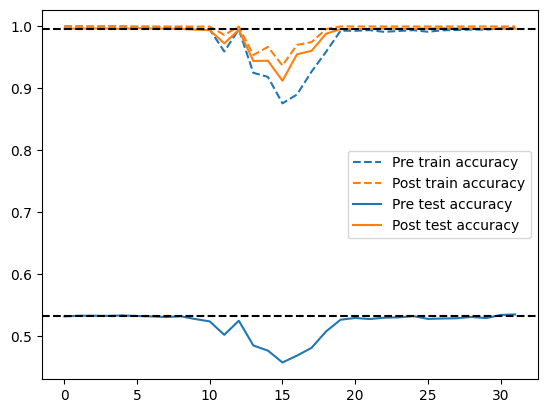

In [39]:
# repeat the above but use chunks of 64 features
results_64 = []
for i in range(0, len(sorted_indices), 64):
    results_64.append(get_train_test_accuracy(sorted_indices[i : i + 64]))
results_64_np = np.array(results_64)
plt.plot(results_64_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_64_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_64_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_64_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

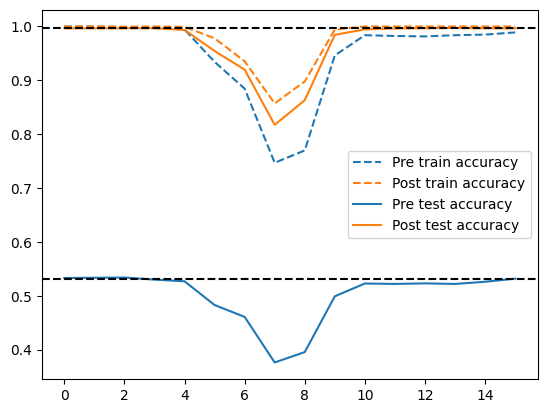

In [40]:
# repeat the above but use chunks of 128 features
results_128 = []
for i in range(0, len(sorted_indices), 128):
    results_128.append(get_train_test_accuracy(sorted_indices[i : i + 128]))
results_128_np = np.array(results_128)
plt.plot(results_128_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_128_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_128_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_128_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

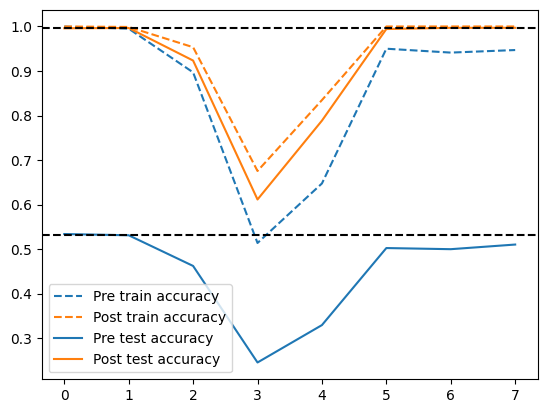

In [41]:
# repeat the above but use chunks of 256 features
results_256 = []
for i in range(0, len(sorted_indices), 256):
    results_256.append(get_train_test_accuracy(sorted_indices[i : i + 256]))
results_256_np = np.array(results_256)
plt.plot(results_256_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_256_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_256_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_256_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

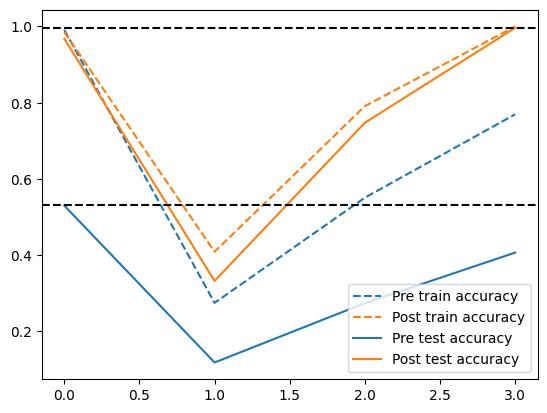

In [42]:
# repeat the above but use chunks of 512 features
results_512 = []
for i in range(0, len(sorted_indices), 512):
    results_512.append(get_train_test_accuracy(sorted_indices[i : i + 512]))
results_512_np = np.array(results_512)
plt.plot(results_512_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_512_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_512_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_512_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

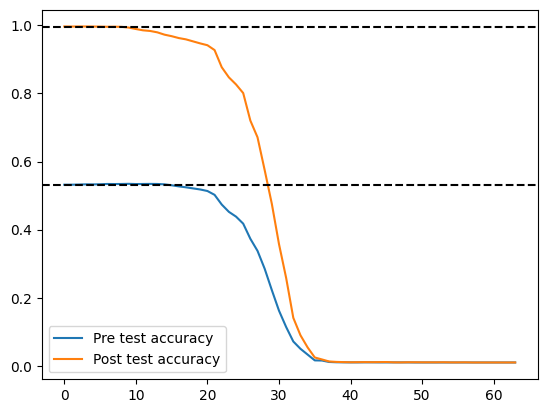

In [43]:
# in chunks of 32 make a cdf of post and pre test accuracy
cdf_results_32 = []
for i in range(0, len(sorted_indices), 32):
    cdf_results_32.append(get_train_test_accuracy(sorted_indices[: i + 32]))
cdf_results_32_np = np.array(cdf_results_32)
plt.plot(cdf_results_32_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(cdf_results_32_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

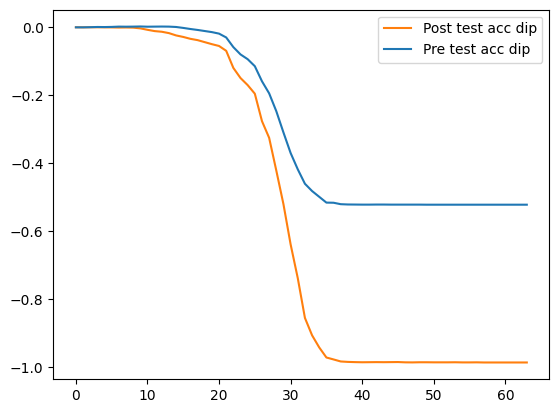

In [46]:
plt.plot(cdf_results_32_np[:, 3] - post_te_acc, label="Post test acc dip", color="C1")
plt.plot(cdf_results_32_np[:, 2] - pre_te_acc, label="Pre test acc dip", color="C0")
plt.legend()

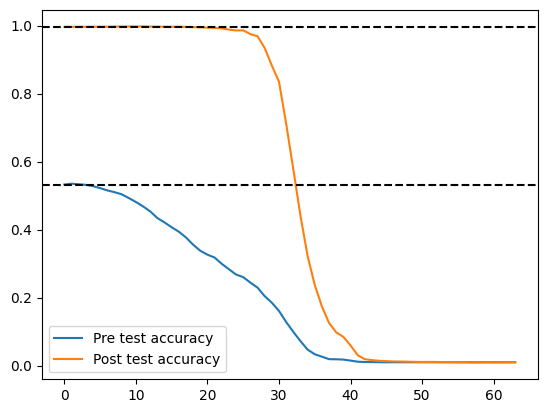

In [47]:
# in chunks of 32 make a cdf of post and pre test accuracy
cdf_results_32_bwd = []
for i in range(0, len(sorted_indices), 32):
    cdf_results_32_bwd.append(get_train_test_accuracy(sorted_indices[-i - 32 :]))
cdf_results_32_bwd_np = np.array(cdf_results_32_bwd)
plt.plot(cdf_results_32_bwd_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(cdf_results_32_bwd_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

# Multiplicative guidance

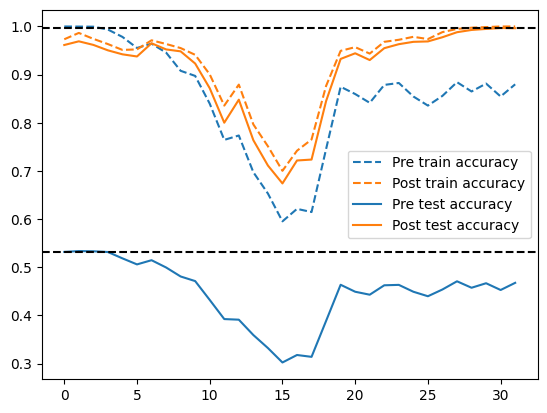

In [60]:
# repeat the above but use chunks of 64 features a
results_64 = []
for i in range(0, len(sorted_indices), 64):
    results_64.append(get_train_test_accuracy(sorted_indices[i : i + 64], -2))
results_64_np = np.array(results_64)
plt.plot(results_64_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_64_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_64_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_64_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

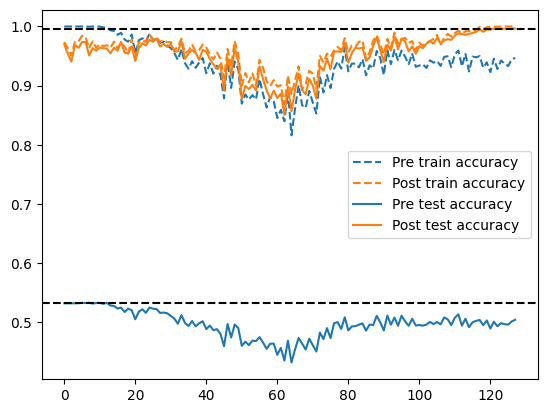

In [62]:
# repeat the above but use chunks of 16 features a
results_16 = []
for i in range(0, len(sorted_indices), 16):
    results_16.append(get_train_test_accuracy(sorted_indices[i : i + 16], -4))
results_16_np = np.array(results_16)
plt.plot(results_16_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_16_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_16_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_16_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

# Clamping Steering

In [15]:
# get max activations for each sparse feature
max_activations = torch.zeros(2048).to(device)
for batch in train_dataloader:
    batch = batch.long()
    batch = batch.to(device)
    x, y = batch[:, :4], batch[:, 4]
    with torch.no_grad():
        zs = [pre_feat(x), post_feat(x)]
        z_normalizing_factors = [
            pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
        ]
        zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
        encoded = addition_cc.encode(zs)  # shape (batch_size, 4, 2048)
        encoded_max = torch.max(encoded, dim=0).values  # shape (4, 2048)
        encoded_max = torch.max(encoded_max, dim=0).values  # shape (2048)
        max_activations = torch.maximum(max_activations, encoded_max)

In [16]:
def get_train_test_accuracy_clamped(feat_idxs: list[int], magnitude: float = 0.0):
    # get train and test accuracy with a cross coder
    pre_train_correct = 0
    pre_train_total = 0
    post_train_correct = 0
    post_train_total = 0
    for batch in train_dataloader:
        batch = batch.long()
        batch = batch.to(device)
        x, y = batch[:, :4], batch[:, 4]
        with torch.no_grad():
            zs = [pre_feat(x), post_feat(x)]
            z_normalizing_factors = [
                pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
            ]
            zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
            encoded = addition_cc.encode(zs)
            encoded[:, :, feat_idxs] = max_activations[feat_idxs] * magnitude
            z_hats = [
                autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
            ]
            z_hats = [
                z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)
            ]
            pre_preds = pre_decoder(z_hats[0])[:, -1, :]
            post_preds = post_decoder(z_hats[1])[:, -1, :]
            pre_train_correct += (pre_preds.argmax(dim=1) == y).sum().item()
            pre_train_total += y.size(0)
            post_train_correct += (post_preds.argmax(dim=1) == y).sum().item()
            post_train_total += y.size(0)

    pre_test_correct = 0
    pre_test_total = 0
    post_test_correct = 0
    post_test_total = 0
    for batch in test_dataloader:
        batch = batch.long()
        batch = batch.to(device)
        x, y = batch[:, :4], batch[:, 4]
        with torch.no_grad():
            zs = [pre_feat(x), post_feat(x)]
            z_normalizing_factors = [
                pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
            ]
            zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
            encoded = addition_cc.encode(zs)
            encoded[:, :, feat_idxs] = max_activations[feat_idxs] * magnitude
            z_hats = [
                autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
            ]
            z_hats = [
                z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)
            ]
            pre_preds = pre_decoder(z_hats[0])[:, -1, :]
            post_preds = post_decoder(z_hats[1])[:, -1, :]
            pre_test_correct += (pre_preds.argmax(dim=1) == y).sum().item()
            pre_test_total += y.size(0)
            post_test_correct += (post_preds.argmax(dim=1) == y).sum().item()
            post_test_total += y.size(0)

    return (
        pre_train_correct / pre_train_total,
        post_train_correct / post_train_total,
        pre_test_correct / pre_test_total,
        post_test_correct / post_test_total,
    )

100%|██████████| 2048/2048 [06:13<00:00,  5.48it/s]


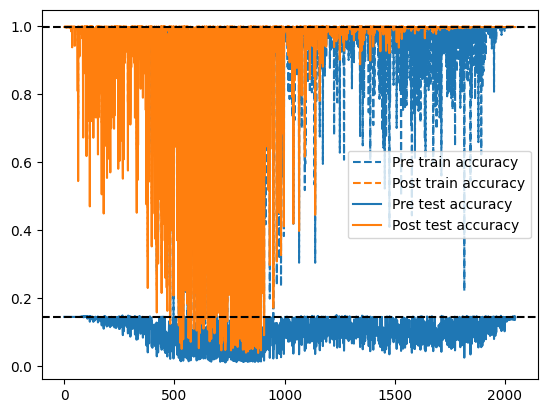

In [17]:
if not os.path.exists("subtraction/results_1.npy"):
    # use clamping on the sparse features
    results_1 = []
    for i in tqdm(range(0, len(sorted_indices), 1)):
        results_1.append(get_train_test_accuracy_clamped(sorted_indices[i : i + 1], 1))
    results_1_np = np.array(results_1)
    np.save("subtraction/results_1.npy", results_1_np)
else:
    results_1_np = np.load("subtraction/results_1.npy")
plt.plot(results_1_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
plt.plot(results_1_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
plt.plot(results_1_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_1_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

100%|██████████| 2048/2048 [06:13<00:00,  5.48it/s]


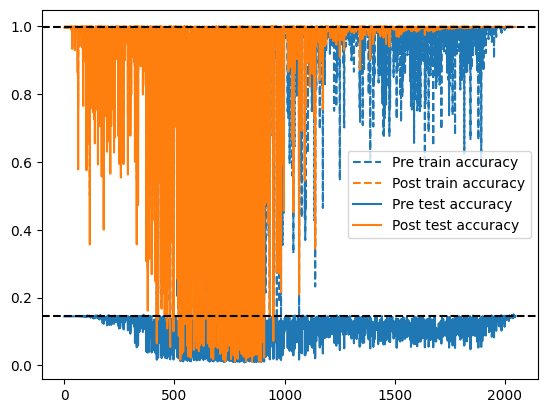

In [18]:
# use clamping on the sparse features
if not os.path.exists("subtraction/results_minus_1.npy"):
    results_minus_1 = []
    for i in tqdm(range(0, len(sorted_indices), 1)):
        results_minus_1.append(
            get_train_test_accuracy_clamped(sorted_indices[i : i + 1], -1)
        )
    results_minus_1_np = np.array(results_minus_1)
    np.save("subtraction/results_minus_1.npy", results_minus_1_np)
else:
    results_minus_1_np = np.load("subtraction/results_minus_1.npy")
plt.plot(
    results_minus_1_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0"
)
plt.plot(
    results_minus_1_np[:, 1], label="Post train accuracy", linestyle="--", color="C1"
)
plt.plot(results_minus_1_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_minus_1_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

100%|██████████| 2048/2048 [02:49<00:00, 12.09it/s]


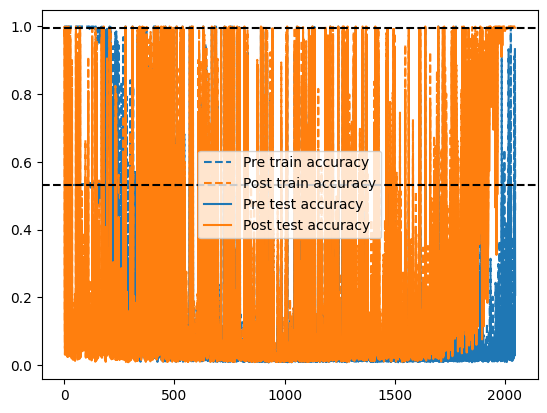

In [34]:
# use clamping on the sparse features
if not os.path.exists("addition/results_minus_5.npy"):
    results_minus_5 = []
    for i in tqdm(range(0, len(sorted_indices), 1)):
        results_minus_5.append(
            get_train_test_accuracy_clamped(sorted_indices[i : i + 1], -5)
        )
    results_minus_5_np = np.array(results_minus_5)
    np.save("addition/results_minus_5.npy", results_minus_5_np)
else:
    results_minus_5_np = np.load("addition/results_minus_5.npy")
plt.plot(
    results_minus_5_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0"
)
plt.plot(
    results_minus_5_np[:, 1], label="Post train accuracy", linestyle="--", color="C1"
)
plt.plot(results_minus_5_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_minus_5_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

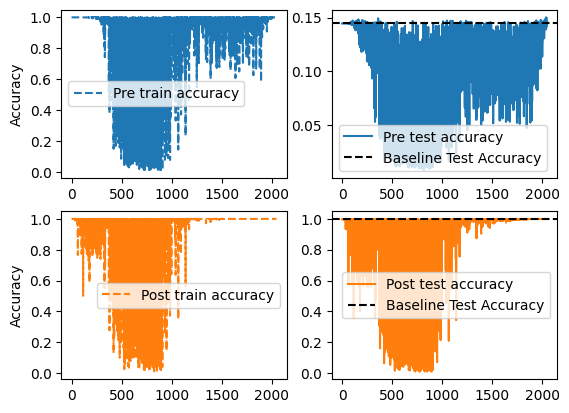

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(
    results_minus_1_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0"
)
ax1.set_ylabel("Accuracy")
ax1.legend()
ax2.plot(results_minus_1_np[:, 2], label="Pre test accuracy", color="C0")
ax2.axhline(pre_te_acc, color="black", linestyle="--", label="Baseline Test Accuracy")
ax2.legend()

ax3.plot(
    results_minus_1_np[:, 1], label="Post train accuracy", linestyle="--", color="C1"
)
ax3.set_ylabel("Accuracy")
ax3.legend()
ax4.plot(results_minus_1_np[:, 3], label="Post test accuracy", color="C1")
ax4.axhline(post_te_acc, color="black", linestyle="--", label="Baseline Test Accuracy")
ax4.legend()

Number of features with post_tr_acc = 1.0 and a drop in post_te_acc: 889


Text(0, 0.5, 'Count')

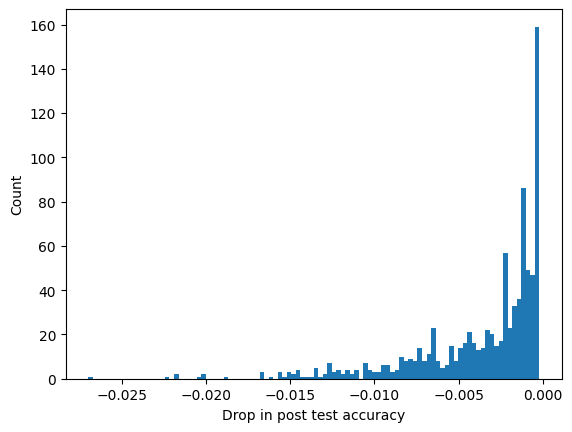

In [20]:
# count the number of features with post_tr_acc = 1.0 and a drop in post_te_acc
perfect_post_train_count = (results_minus_1_np[:, 1] == 1.0) & (
    results_minus_1_np[:, 3] < post_te_acc
)
print(
    f"Number of features with post_tr_acc = 1.0 and a drop in post_te_acc: {perfect_post_train_count.sum()}"
)
# make a histogram of the drops in post test accuracy
plt.hist(results_minus_1_np[perfect_post_train_count, 3] - post_te_acc, bins=100)
plt.xlabel("Drop in post test accuracy")
plt.ylabel("Count")

In [ ]:
# count number of features that are generalization only (rel norm <= 0.05) that lead to
# a drop in post test accuracy and maintain a post train accuracy of 1.0
post_generalization_only_features = len(
    sorted_indices[
        (addition_relative_norms[sorted_indices].numpy(force=True) <= 0.05)
        & (results_minus_1_np[:, 1] == 1.0)
        & (results_minus_1_np[:, 3] < post_te_acc)
    ]
)
post_only_features = (
    addition_relative_norms[sorted_indices].numpy(force=True) <= 0.05
).sum()

pre_generalization_only_features = len(
    sorted_indices[
        (addition_relative_norms[sorted_indices].numpy(force=True) >= 0.95)
        & (results_minus_1_np[:, 1] == 1.0)
        & (results_minus_1_np[:, 3] < post_te_acc)
    ]
)
pre_only_features = (
    addition_relative_norms[sorted_indices].numpy(force=True) >= 0.95
).sum()

rest_generalization_only_features = len(
    sorted_indices[
        (addition_relative_norms[sorted_indices].numpy(force=True) > 0.05)
        & (addition_relative_norms[sorted_indices].numpy(force=True) < 0.95)
        & (results_minus_1_np[:, 1] == 1.0)
        & (results_minus_1_np[:, 3] < post_te_acc)
    ]
)
rest_features = (
    (addition_relative_norms[sorted_indices].numpy(force=True) > 0.05)
    & (addition_relative_norms[sorted_indices].numpy(force=True) < 0.95)
).sum()

# compare ratios
print(f"N_post_only_features: {post_only_features}")
print(f"N_rest_features: {rest_features}")
print(f"N_pre_only_features: {pre_only_features}")
print(f"N_post_generalization_only_features: {post_generalization_only_features}")
print(f"N_rest_generalization_only_features: {rest_generalization_only_features}")
print(f"N_pre_generalization_only_features: {pre_generalization_only_features}")
print(
    f"Ratio of post only features: {post_generalization_only_features / post_only_features}"
)
print(
    f"Ratio of rest generalization only features: {rest_generalization_only_features / rest_features}"
)
print(
    f"Ratio of pre generalization only features: {pre_generalization_only_features / pre_only_features}"
)

N_post_only_features: 95
N_rest_features: 1859
N_pre_only_features: 94
N_post_generalization_only_features: 61
N_rest_generalization_only_features: 828
N_pre_generalization_only_features: 0
Ratio of post only features: 0.6421052631578947
Ratio of rest generalization only features: 0.44540075309306076
Ratio of pre generalization only features: 0.0


![we're chic squared sig](addition/Post%20Gen%20Chi-Squared.png)

In [22]:
# find the set of features with post_tr_acc = 1.0
perfect_train_idx = sorted_indices[results_minus_1_np[:, 1] == 1.0].cpu()

In [23]:
# sort the perfect_train_idx by the train acc - test acc
perfect_train_idx_sorted_by_acc = np.argsort(
    results_minus_1_np[perfect_train_idx, 1] - results_minus_1_np[perfect_train_idx, 3]
)
# sort by relative norm
perfect_train_idx_sorted_by_norm = np.argsort(
    addition_relative_norms.to("cpu")[perfect_train_idx]
)

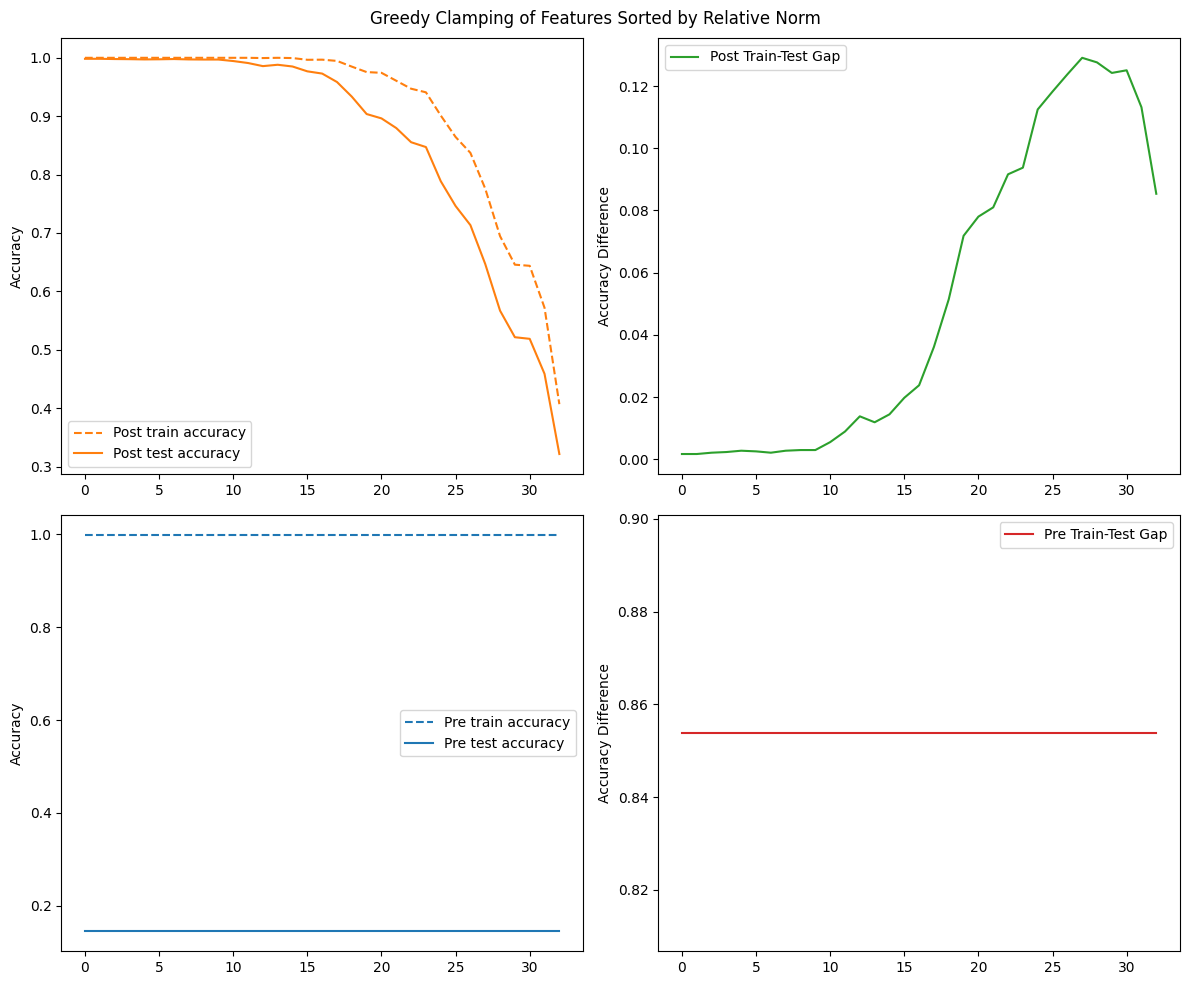

In [25]:
# greedily zero out the first n features cumulatively and clamp the features to -1
results_cum = []
n = 32
for i in range(0, n + 1):
    # perfect_train_idx_sorted_by_norm_reversed = perfect_train_idx_sorted_by_norm.flip(0)
    idx_to_clamp = perfect_train_idx[perfect_train_idx_sorted_by_norm[:i]]
    results_cum.append(get_train_test_accuracy_clamped(idx_to_clamp, -0.6))
results_cum_np = np.array(results_cum)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Top left plot - post model accuracies
ax1.plot(results_cum_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
ax1.plot(results_cum_np[:, 3], label="Post test accuracy", color="C1")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Top right plot - post model train/test difference
post_train_test_diff = results_cum_np[:, 1] - results_cum_np[:, 3]
ax2.plot(post_train_test_diff, label="Post Train-Test Gap", color="C2")
ax2.set_ylabel("Accuracy Difference")
ax2.legend()

# Bottom left plot - pre model accuracies
ax3.plot(results_cum_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
ax3.plot(results_cum_np[:, 2], label="Pre test accuracy", color="C0")
ax3.set_ylabel("Accuracy")
ax3.legend()

# Bottom right plot - pre model train/test difference
pre_train_test_diff = results_cum_np[:, 0] - results_cum_np[:, 2]
ax4.plot(pre_train_test_diff, label="Pre Train-Test Gap", color="C3")
ax4.set_ylabel("Accuracy Difference")
ax4.legend()

# title the figure
plt.suptitle("Greedy Clamping of Features Sorted by Relative Norm")
plt.tight_layout()
plt.show()

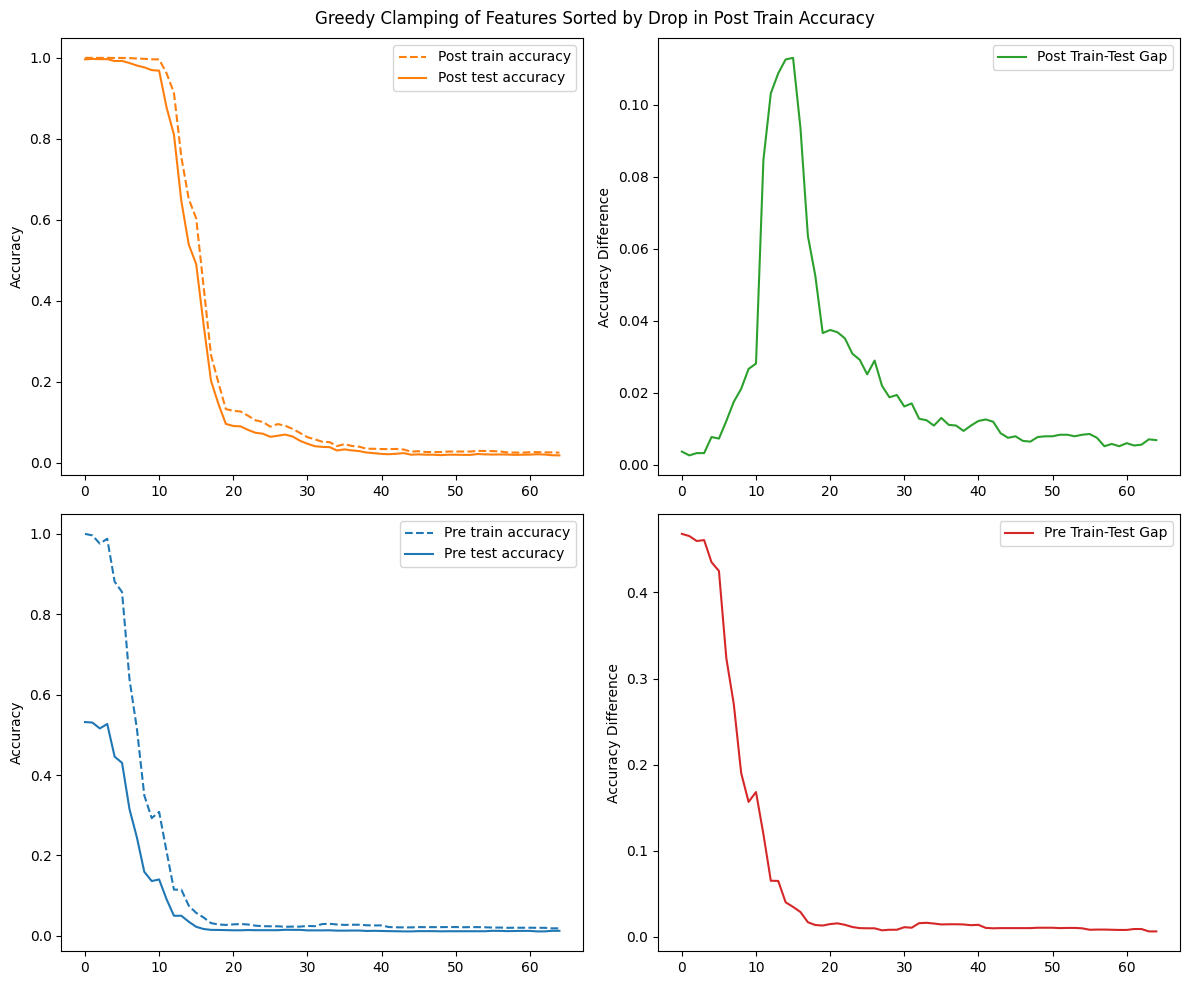

In [24]:
# greedily zero out the first n features cumulatively and clamp the features to -1
results_cum = []
n = 64
for i in range(0, n + 1):
    # perfect_train_idx_sorted_by_norm_reversed = perfect_train_idx_sorted_by_norm.flip(0)
    idx_to_clamp = perfect_train_idx[perfect_train_idx_sorted_by_acc[:i]]
    results_cum.append(get_train_test_accuracy_clamped(idx_to_clamp, -0.6))
results_cum_np = np.array(results_cum)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Top left plot - post model accuracies
ax1.plot(results_cum_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
ax1.plot(results_cum_np[:, 3], label="Post test accuracy", color="C1")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Top right plot - post model train/test difference
post_train_test_diff = results_cum_np[:, 1] - results_cum_np[:, 3]
ax2.plot(post_train_test_diff, label="Post Train-Test Gap", color="C2")
ax2.set_ylabel("Accuracy Difference")
ax2.legend()

# Bottom left plot - pre model accuracies
ax3.plot(results_cum_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
ax3.plot(results_cum_np[:, 2], label="Pre test accuracy", color="C0")
ax3.set_ylabel("Accuracy")
ax3.legend()

# Bottom right plot - pre model train/test difference
pre_train_test_diff = results_cum_np[:, 0] - results_cum_np[:, 2]
ax4.plot(pre_train_test_diff, label="Pre Train-Test Gap", color="C3")
ax4.set_ylabel("Accuracy Difference")
ax4.legend()

# title the figure
plt.suptitle("Greedy Clamping of Features Sorted by Drop in Post Train Accuracy")
plt.tight_layout()
plt.show()

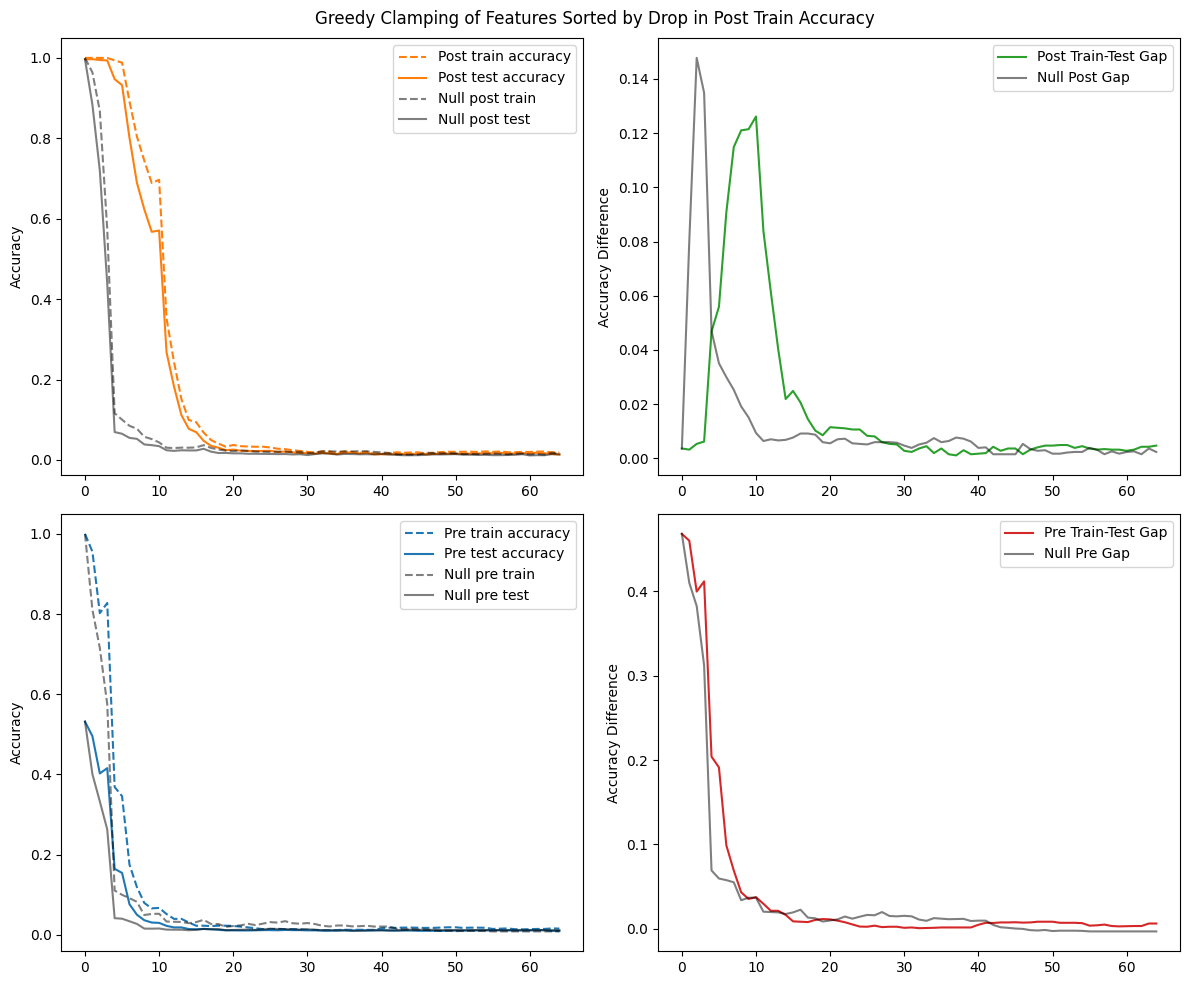

In [21]:
# greedily zero out the first n features cumulatively and clamp the features to -1
results_cum = []
results_cum_null = []
n = 64
clamping_magnitude = -1

# Get sorted results
for i in range(0, n + 1):
    idx_to_clamp = perfect_train_idx[perfect_train_idx_sorted_by_acc[:i]]
    results_cum.append(
        get_train_test_accuracy_clamped(idx_to_clamp, clamping_magnitude)
    )

# Get null hypothesis results with random features
random_idx = torch.randperm(2048)
for i in range(0, n + 1):
    idx_to_clamp = random_idx[:i]
    results_cum_null.append(
        get_train_test_accuracy_clamped(idx_to_clamp, clamping_magnitude)
    )

results_cum_np = np.array(results_cum)
results_cum_null_np = np.array(results_cum_null)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Top left plot - post model accuracies
ax1.plot(results_cum_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
ax1.plot(results_cum_np[:, 3], label="Post test accuracy", color="C1")
ax1.plot(
    results_cum_null_np[:, 1],
    label="Null post train",
    linestyle="--",
    color="black",
    alpha=0.5,
)
ax1.plot(results_cum_null_np[:, 3], label="Null post test", color="black", alpha=0.5)
ax1.set_ylabel("Accuracy")
ax1.legend()

# Top right plot - post model train/test difference
post_train_test_diff = results_cum_np[:, 1] - results_cum_np[:, 3]
post_train_test_diff_null = results_cum_null_np[:, 1] - results_cum_null_np[:, 3]
ax2.plot(post_train_test_diff, label="Post Train-Test Gap", color="C2")
ax2.plot(post_train_test_diff_null, label="Null Post Gap", color="black", alpha=0.5)
ax2.set_ylabel("Accuracy Difference")
ax2.legend()

# Bottom left plot - pre model accuracies
ax3.plot(results_cum_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
ax3.plot(results_cum_np[:, 2], label="Pre test accuracy", color="C0")
ax3.plot(
    results_cum_null_np[:, 0],
    label="Null pre train",
    linestyle="--",
    color="black",
    alpha=0.5,
)
ax3.plot(results_cum_null_np[:, 2], label="Null pre test", color="black", alpha=0.5)
ax3.set_ylabel("Accuracy")
ax3.legend()

# Bottom right plot - pre model train/test difference
pre_train_test_diff = results_cum_np[:, 0] - results_cum_np[:, 2]
pre_train_test_diff_null = results_cum_null_np[:, 0] - results_cum_null_np[:, 2]
ax4.plot(pre_train_test_diff, label="Pre Train-Test Gap", color="C3")
ax4.plot(pre_train_test_diff_null, label="Null Pre Gap", color="black", alpha=0.5)
ax4.set_ylabel("Accuracy Difference")
ax4.legend()

# title the figure
plt.suptitle("Greedy Clamping of Features Sorted by Drop in Post Train Accuracy")
plt.tight_layout()
plt.show()

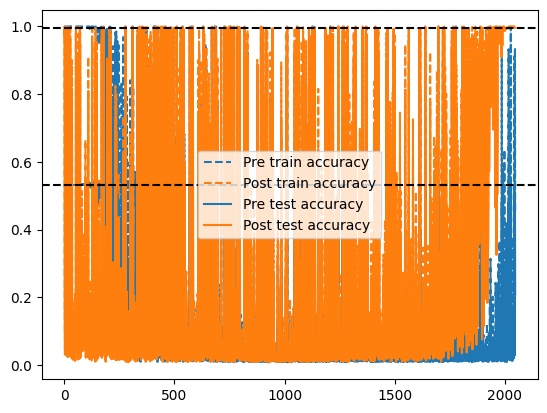

In [67]:
# use clamping on the sparse features
results_minus_5 = []
for i in range(0, len(sorted_indices), 1):
    results_minus_5.append(
        get_train_test_accuracy_clamped(sorted_indices[i : i + 1].to(device), -5)
    )
results_minus_5_np = np.array(results_minus_5)
plt.plot(
    results_minus_5_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0"
)
plt.plot(
    results_minus_5_np[:, 1], label="Post train accuracy", linestyle="--", color="C1"
)
plt.plot(results_minus_5_np[:, 2], label="Pre test accuracy", color="C0")
plt.plot(results_minus_5_np[:, 3], label="Post test accuracy", color="C1")
plt.axhline(pre_te_acc, color="black", linestyle="--")
plt.axhline(post_te_acc, color="black", linestyle="--")
plt.legend()

In [ ]:
# get the perfect training acc idxs
perfect_minus_5_idx = sorted_indices[results_minus_5_np[:, 1] == 1.0].cpu()

# sort the perfect_minus_5_idx by the train acc - test acc
perfect_minus_5_idx_sorted_by_acc = np.argsort(
    results_minus_5_np[perfect_minus_5_idx, 1]
    - results_minus_5_np[perfect_minus_5_idx, 3]
)
# sort by relative norm
perfect_minus_5_idx_sorted_by_norm = np.argsort(
    addition_relative_norms.to("cpu")[perfect_minus_5_idx]
)

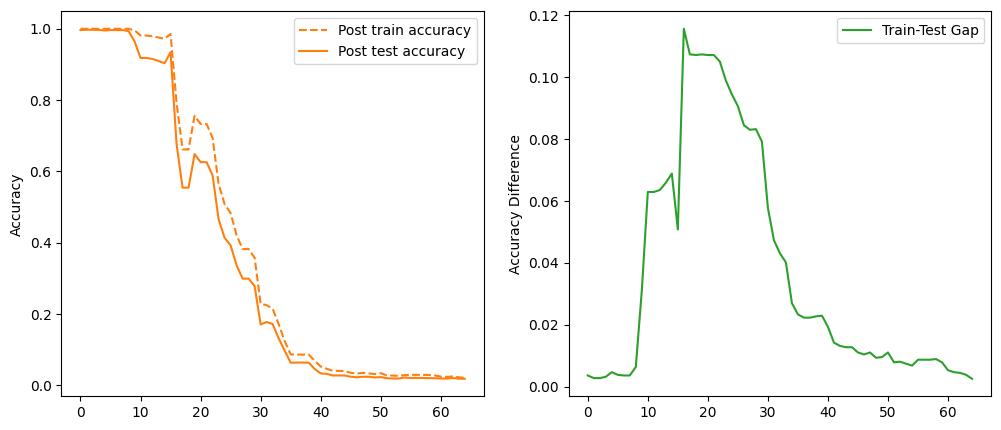

In [114]:
# greedily clamp the first 10 features to -5
n = 64
results_cum = []
for i in range(0, n + 1):
    idx_to_clamp = perfect_minus_5_idx[perfect_minus_5_idx_sorted_by_acc[:i]]
    results_cum.append(get_train_test_accuracy_clamped(idx_to_clamp, -5))
results_cum_np = np.array(results_cum)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Left plot - original accuracies
ax1.plot(results_cum_np[:, 1], label="Post train accuracy", linestyle="--", color="C1")
ax1.plot(results_cum_np[:, 3], label="Post test accuracy", color="C1")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Right plot - train/test difference
train_test_diff = results_cum_np[:, 1] - results_cum_np[:, 3]
ax2.plot(train_test_diff, label="Train-Test Gap", color="C2")
ax2.set_ylabel("Accuracy Difference")
ax2.legend()

# The Features of *memorization*

N_memorization_features: 38


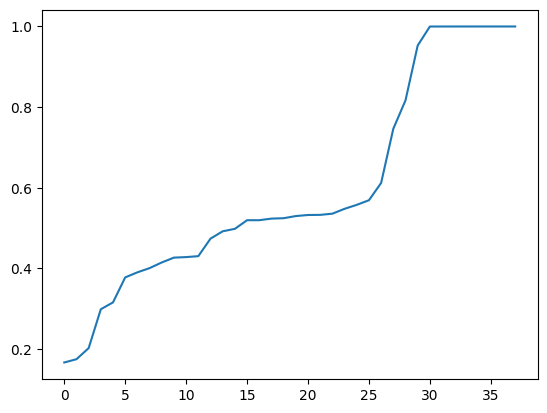

In [29]:
# find features in with pre_tr_acc < 1.0 and pre_te_acc >= pre_te_acc
memorization_features = sorted_indices[
    (results_minus_1_np[:, 0] < pre_tr_acc) & (results_minus_1_np[:, 2] >= pre_te_acc)
]
print(f"N_memorization_features: {len(memorization_features)}")
# plot the relative norm of the memorization features
plt.plot(
    addition_relative_norms[memorization_features].numpy(force=True),
    label="Relative Norm",
)

(array([26.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0.,  1.]),
 array([0.00191286, 0.00195537, 0.00199787, 0.00204038, 0.00208289,
        0.0021254 , 0.00216791, 0.00221041, 0.00225292, 0.00229543,
        0.00233794]),
 <BarContainer object of 10 artists>)

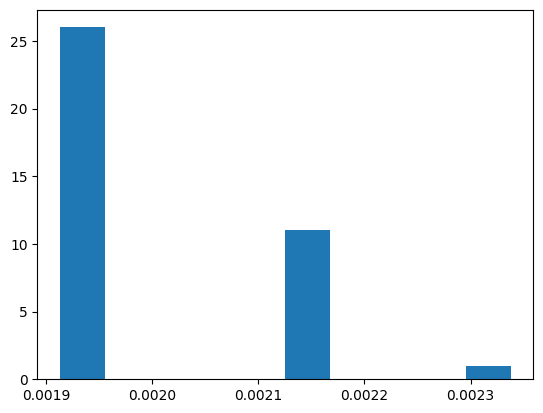

In [31]:
# plot distribution of drop in train acc
plt.hist(
    1
    - results_minus_1_np[
        (results_minus_1_np[:, 0] < pre_tr_acc)
        & (results_minus_1_np[:, 2] >= pre_te_acc),
        0,
    ]
)

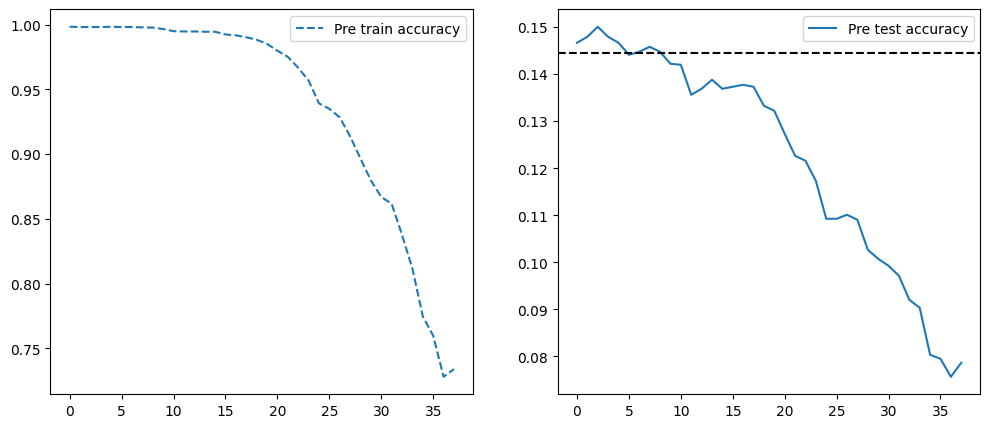

In [34]:
# cumulatively clamp out the memorization features and plot the post train and post test accuracy
results_cum = []
for i in range(len(memorization_features)):
    idx_to_clamp = memorization_features[-i - 1 :]
    results_cum.append(get_train_test_accuracy_clamped(idx_to_clamp, -0.5))
results_cum_np = np.array(results_cum)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(results_cum_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
ax2.plot(results_cum_np[:, 2], label="Pre test accuracy", color="C0")
ax2.axhline(pre_te_acc, color="black", linestyle="--")
ax1.legend()
ax2.legend()
plt.show()

N_memorization_features: 75


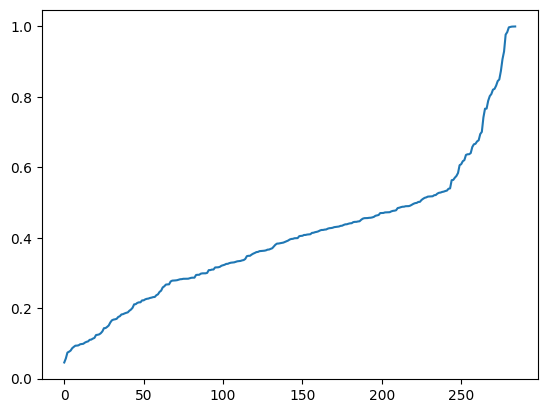

In [35]:
# retrying with minus 5
memorization_features_minus_5 = sorted_indices[
    (results_minus_5_np[:, 0] < 1.0) & (results_minus_5_np[:, 2] >= pre_te_acc)
]
print(f"N_memorization_features: {len(memorization_features_minus_5)}")
# plot the relative norm of the memorization features
plt.plot(
    addition_relative_norms[memorization_features].numpy(force=True),
    label="Relative Norm",
)

(array([50.,  6.,  4.,  8.,  0.,  2.,  2.,  1.,  0.,  2.]),
 array([0.00021254, 0.00076514, 0.00131775, 0.00187035, 0.00242295,
        0.00297556, 0.00352816, 0.00408077, 0.00463337, 0.00518597,
        0.00573858]),
 <BarContainer object of 10 artists>)

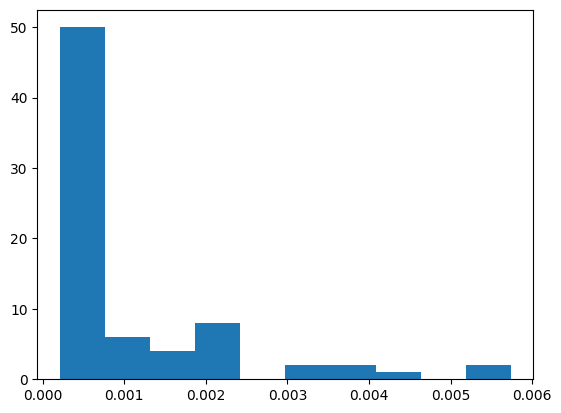

In [ ]:
# plot distribution of drop in train acc
plt.hist(
    1
    - results_minus_5_np[
        (results_minus_5_np[:, 0] < 1.0) & (results_minus_5_np[:, 2] >= pre_te_acc), 0
    ]
)

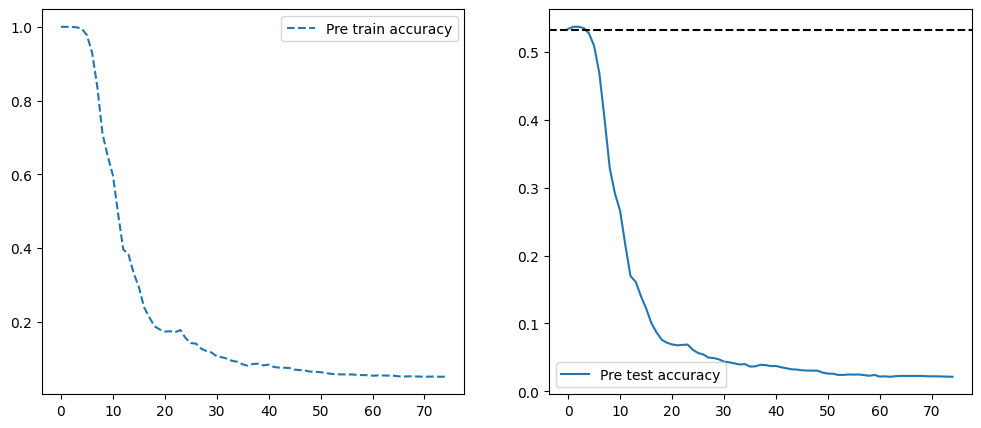

In [ ]:
# cumulatively clamp out the memorization features and plot the post train and post test accuracy
results_cum = []
for i in range(len(memorization_features_minus_5)):
    idx_to_clamp = memorization_features_minus_5[-i - 1 :]
    results_cum.append(get_train_test_accuracy_clamped(idx_to_clamp, -2))
results_cum_np = np.array(results_cum)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.plot(results_cum_np[:, 0], label="Pre train accuracy", linestyle="--", color="C0")
ax2.plot(results_cum_np[:, 2], label="Pre test accuracy", color="C0")
ax2.axhline(pre_te_acc, color="black", linestyle="--")
ax1.legend()
ax2.legend()
ax3.plot()
plt.show()

# Null Hypothesis Testing
- [ ] a